# Building a Robot Judge 2019 - Problem Set
Author: Simon Schaefer

### Problem Set III

In [8]:
import glob
import os
import pandas

# Loading text data and reversed flags to dataframe. The data are assumed to be in 
# the DATA_PATH directory, i.e. the description file as "case_reversed.csv" and the 
# texts in the subdirectory "cases/". 
DATA_PATH = "../data/"
cases_df  = pandas.read_csv(DATA_PATH + "case_metadata.csv") 
cases_df  = cases_df.sample(n=min(500, len(cases_df)))  # due to low performance of my laptop
cases_df  = cases_df.dropna()
cases_df  = cases_df.sort_index()
texts = []
for x in cases_df['caseid']: 
    file_path = glob.glob(DATA_PATH + "cases/*" + str(x) + ".txt")
    assert len(file_path) == 1
    file_path = file_path[0]
    f = open(file_path, 'r')
    texts.append(f.read())
cases_df['text'] = texts
del texts
cases_df.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites,text
18,X3U0CQ,0,1231.0,1925.0,1.0,1.609438,"LEWIS , Circuit Judge.\nThe appellant filed i..."
29,X3CETE,0,37.0,1926.0,0.0,2.302585,"ANDERSON , Circuit Judge.\nOn an information ..."
61,X3LJ7C,0,2131.0,1928.0,1.0,1.098612,"VAN VALKENBURGH , Circuit Judge.\nOn the 8th ..."
110,X2D6MI,0,1299.0,1930.0,0.0,2.197225,"MANTON , Circuit Judge.\nPrior to March 1, 19..."
116,X3M3KP,0,1795.0,1930.0,1.0,1.098612,"RUDKIN , Circuit Judge.\nThis was a proceedin..."


In [9]:
import spacy

nlp = spacy.load('en') # loading the language model 

def clean_up(text): 
    removal=['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE']
    text_out = []
    doc= nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_alpha and len(token)>2 and token.pos_ not in removal:
            lemma = str(token).lower()
            text_out.append(lemma)
    return text_out
    
cases_df['text'] = cases_df.text.apply(lambda x:clean_up(x))

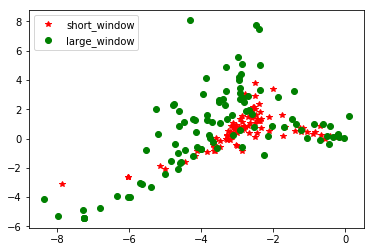

In [10]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
from random import randint

# Train two word2vec models - 1) small window 2) large window. 
size = 2
model_sw = Word2Vec(cases_df['text'], size=size, window=2, min_count=1, workers=4)
model_lw = Word2Vec(cases_df['text'], size=size, window=16, min_count=1, workers=4)

# Generate random set of words. 
test_words = []
while len(test_words) < 100: 
    row = cases_df.sample(n=1)['text'].tolist()[0]
    ti = randint(0, len(row)-1)
    test_words.append(row[ti])
    
# Apply models to random test words set. 
sw_vecs, lw_vecs = np.zeros((len(test_words),size)), np.zeros((len(test_words),size))
for iw, word in enumerate(test_words): 
    sw_vecs[iw,:] = model_sw.wv[word]
    lw_vecs[iw,:] = model_lw.wv[word]
    
# Plot vector sets. 
plt.plot(sw_vecs[:,0], sw_vecs[:,1], 'r*', label='short_window')
plt.plot(lw_vecs[:,0], lw_vecs[:,1], 'go', label='large_window')
plt.legend()

For Word2Vec models larger window sizes tend to capture more domain information while smaller window sizes usually learn more about the word itself, e.g. similar words. Depending on the data distribution a larger window size also may pull the embedded vectors tighter together, especially if there are words occuring in a lot of training samples. For this reason stopwords has been removed before training. However, in the example above, in which the word2vec models are trained in one dataset only, the smaller window size leads to a larger density (and accordingly smaller spreading) of the words in the embedded space. Therefore, in the cases dataset very similar words seem to occur but very different topic/domains seem to be dealt with. As similarity measure the cosine similarty is used. 

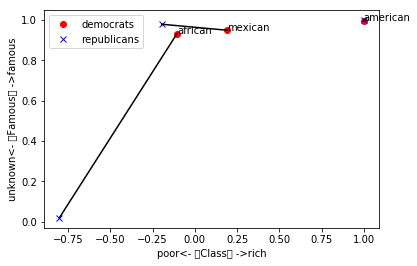

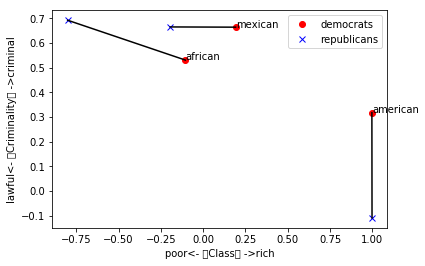

In [11]:
import matplotlib.pyplot as plt
import numpy as np

dem_df = cases_df[cases_df['x_republican'] == False]
rep_df = cases_df[cases_df['x_republican'] == True]

# Kozlowski et al 2018: Analyse the shifts between ethnology related words in several coordinates by party.
def get_nn_coord(vec, comp_vecs): 
    assert comp_vecs.shape[0] == 2
    assert vec.shape[0] == comp_vecs.shape[1] 
    dist_0 = np.linalg.norm(vec - comp_vecs[0,:])
    dist_1 = np.linalg.norm(vec - comp_vecs[1,:])
    return np.dot(vec - comp_vecs[0,:], vec - comp_vecs[1,:])/(dist_0*dist_1)

model_dem = Word2Vec(dem_df['text'], size=20, window=16, min_count=1, workers=4)
model_rep = Word2Vec(rep_df['text'], size=20, window=16, min_count=1, workers=4)

def plot_cat_shifts(base_words, cat1_words, cat2_words, cat1, cat2): 
    na_coords = np.zeros((2,len(base_words),2))
    for im, model in enumerate([model_dem, model_rep]): 
        cat1_vecs = np.asarray([model.wv[cat1_words[0]], model.wv[cat1_words[1]]])
        cat2_vecs  = np.asarray([model.wv[cat2_words[0]], model.wv[cat2_words[1]]])
        for iw, word in enumerate(base_words): 
            vec = model.wv[word]
            na_coords[im, iw, 0] = get_nn_coord(vec, cat1_vecs)
            na_coords[im, iw, 1] = get_nn_coord(vec, cat2_vecs)

    plt.figure()
    plt.plot(na_coords[0,:,0],na_coords[0,:,1], 'ro', label="democrats")
    plt.plot(na_coords[1,:,0],na_coords[1,:,1], 'bx', label="republicans")
    plt.plot(na_coords[:,:,0], na_coords[:,:,1], 'k-')
    for iw, word in enumerate(base_words): 
        plt.text(na_coords[0,iw,0],na_coords[0,iw,1],word)
    plt.xlabel(cat1_words[0] + "<- \t" + cat1 + "\t ->" + cat1_words[1])
    plt.ylabel(cat2_words[0] + "<- \t" + cat2 + "\t ->" + cat2_words[1])
    plt.legend()

ethnology_words = ["american", "mexican", "african"] 
# not in voc: hispanoamerican, afroamerican, asian, hispanic, latino, italian

cat1_words = ["poor", "rich"]
cat2_words = ["unknown", "famous"]
plot_cat_shifts(ethnology_words, cat1_words, cat2_words, cat1="Class", cat2="Famous")

cat1_words = ["poor", "rich"]
cat2_words = ["lawful", "criminal"]
plot_cat_shifts(ethnology_words, cat1_words, cat2_words, cat1="Class", cat2="Criminality")

The results fit pretty well to the "stereotypic" opinion about both of the party's attitudes about ethnicities, (native) americans are richer and less criminal than other ethnicities, according to the republicans, while democrats seems to see it a little less polalized (although still having some bias). 

In [43]:
# Extracting text features (word counts). 
from collections import Counter
from itertools import chain
import numpy as np

unique_words  = list(Counter(list(chain(*cases_df['text']))).keys())
unique_dict   = {unique_words[i]: i for i in range(len(unique_words))}

def word_count(x): 
    X = np.zeros((len(unique_words),1))
    for k,v in Counter(x).items(): X[unique_dict[k]] = v
    return X

cases_df['features'] = cases_df.text.apply(lambda x:word_count(x))
cases_df.head()

,caseid,case_reversed,judge_id,year,x_republican,log_cites,text,features
18,X3U0CQ,0,1231.0,1925.0,1.0,1.609438,"[lewis, circuit, judge, appellant, filed, comp...","[[1.0], [1.0], [2.0], [10.0], [3.0], [2.0], [3..."
29,X3CETE,0,37.0,1926.0,0.0,2.302585,"[anderson, circuit, judge, information, counts...","[[0.0], [3.0], [2.0], [0.0], [0.0], [0.0], [1...."
61,X3LJ7C,0,2131.0,1928.0,1.0,1.098612,"[van, valkenburgh, circuit, judge, day, octobe...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2...."
110,X2D6MI,0,1299.0,1930.0,0.0,2.197225,"[manton, circuit, judge, march, march, petitio...","[[0.0], [1.0], [1.0], [0.0], [0.0], [0.0], [0...."
116,X3M3KP,0,1795.0,1930.0,1.0,1.098612,"[rudkin, circuit, judge, proceeding, informati...","[[0.0], [3.0], [5.0], [0.0], [0.0], [0.0], [4...."


In the following the effect of the political party on reversals will be analysed while holding text features constant, using the double ML method which was proposed by Chernozhukov et al (2017). The double ML method there is assumed to be a high-dimensional set of observed cofounders A, which effect both the variable T and the output Y which is 

$$ Y = \theta * T + g(A) + \epsilon $$

In the analysed use case we want to predict the effect of the political party (T) on the reversals (Y). As shown above the political party does have an influence on which words are used and it is assumed that they are also affecting the reversals (which is shown later on). As text feature a simple word count of the preprocessed texts is used. For better performance sample split with a half-half split is used. 

In [73]:
import numpy as np
from sklearn.linear_model import LinearRegression

A = cases_df['features'].values
A = np.vstack(A)
A = np.reshape(A, (len(cases_df), len(unique_words)))
Y = cases_df['case_reversed'].values
T = cases_df['x_republican'].values

num_split = len(cases_df)//2
Aa = A[:num_split,:]; Ya = Y[:num_split]; Ta = T[:num_split]
Ab = A[num_split:,:]; Yb = Y[num_split:]; Tb = T[num_split:]

#1) Predict Y given A: Y_hat(A), and T given A: T_hat(A) using OLS.
Y_hat_A_a = LinearRegression().fit(Aa, Ya)
T_hat_A_a = LinearRegression().fit(Aa, Ta)
Y_hat_A_b = LinearRegression().fit(Ab, Yb)
T_hat_A_b = LinearRegression().fit(Ab, Tb)

#2) Form residuals Y_tilde = Y − Y_hat(A) and T_tilde = T − T_hat(A). 
Y_tilde_a = Ya - Y_hat_A_b.predict(Aa)
T_tilde_a = Ta - T_hat_A_b.predict(Aa)
Y_tilde_b = Yb - Y_hat_A_a.predict(Ab)
T_tilde_b = Tb - T_hat_A_a.predict(Ab)

#3) Regress Y_tilde on T_tilde to learn θ_hat.
Y_tilde_a = np.reshape(Y_tilde_a, (num_split,1))
Y_tilde_b = np.reshape(Y_tilde_b, (num_split,1))
theta_hat_a = LinearRegression().fit(Y_tilde_a, T_tilde_a)
theta_hat_b = LinearRegression().fit(Y_tilde_b, T_tilde_b)
theta_hat = (theta_hat_a.coef_ + theta_hat_b.coef_)/2.0
print(theta_hat)

[0.01254384]


As shown above the party has a slightly positive effect on reversals, i.e. the more republican the judge is the more likely a reversal is.